# CW04 - GUI paper exploration 2 - Bayesian evidence

Motivation: Demonstration of getting Bayesian evidence out of swyft, already after one round.

In [1]:
# Makes it easier to debug
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pylab as plt
from scipy.linalg import inv
from scipy import stats
import scipy
import torch

In [3]:
import dynesty
import swyft

## Workflow: ZoomTask

In [4]:
class ZoomTask:
    def __init__(self, sim_or_store, prior, target_obs, partition = None, simhook = None, init_bound = None):
        if not isinstance(sim_or_store, swyft.Simulator):
            self.store = sim_or_store
        else:
            self.store = swyft.MemoryStore(sim)
        
        if partition is None:
            self.partition = list(range(len(self.store.pnames)))
        else:
            self.partition = partition
            
        self.prior = prior
        self.simhook = simhook
        self.target_obs = target_obs
        
        self.init_bound = init_bound
        self.last_bound = None
        self.history = []
        
    def run(self, rounds = 10, N = 10000, train_args = {}, head = None):
        for i in range(rounds):
            self.round(N = N, train_args = train_args, head = head)
        
    def round(self, N, train_args = {}, head = None):
        bound = self.init_bound if self.history == [] else self.history[-1][1]
        
        self.store.add(N, self.prior, bound = bound)
        self.store.simulate()
        dataset = swyft.Dataset(N, self.prior, self.store, simhook = self.simhook, bound = bound)
        post = swyft.Posteriors(dataset)
        post.add(self.partition, device='cuda', head = head, tail_args = dict(p=0.2, hidden_layers = [512, 512]))
        post.train(self.partition, **train_args)
        bound = post.truncate(self.partition, self.target_obs)
        
        self.history.append([post, bound])

## Model

In [5]:
COUNTER = 0  # Counter for number of likelihood evaluations (relevant for Dynesty)

In [6]:
N = 64  # Number of data bins
SIGMA = 1.0  # Measurement uncertainty

In [8]:
# Noise-free model

# Model and reference parameters
def spec(a, b, c, d, LW = 0.3):
    global COUNTER
    COUNTER += 1
    x = np.linspace(0, 10, N)
    y_bg = a+x*b
    y_sig = c*stats.norm.pdf(x, d, LW)
    return y_bg + y_sig

def model(v):
    y = spec(v[0], v[1], v[2], v[3])
    noise = 0*np.random.randn(N)*SIGMA
    return dict(y=y + noise)

# Noise model
def noise(sim, v, sigma = SIGMA):
    #return sim
    noise = np.random.randn(N)*sigma
    return dict(y = sim['y'] + noise)

## Dynesty analysis

In [25]:
# Prior
def transform(u):
    a = scipy.stats.uniform(-2., 4.).ppf(u[0])
    b = scipy.stats.uniform(-.5, 1.).ppf(u[1])
    c = scipy.stats.uniform(0, 10.).ppf(u[2])
    d = scipy.stats.uniform(3.5, 1.).ppf(u[3])
    return np.array([a, b, c, d])

In [26]:
v0 = np.array([0.0, 0, 2., 4.])
obs0 = noise(model(v0), v0)

In [27]:
def loglike(v):    
    mu = model(v)['y']
    return -0.5*sum((obs0['y'] - mu)**2)

In [28]:
ns = dynesty.NestedSampler(loglike, transform, 4)
ns.run_nested()
print(COUNTER)

62it [00:00, 290.19it/s, bound: 0 | nc: 1 | ncall: 566 | eff(%): 10.954 | loglstar:   -inf < -408.474 <    inf | logz: -414.710 +/-  0.149 | dlogz: 393.648 >  0.509]

2 0.002


1771it [00:52, 28.95it/s, bound: 1 | nc: 1 | ncall: 17650 | eff(%): 10.034 | loglstar:   -inf < -35.263 <    inf | logz: -40.989 +/-  0.139 | dlogz: 17.601 >  0.509]  

3 5.9170420772588055e-05


2005it [00:54, 90.81it/s, bound: 2 | nc: 1 | ncall: 18414 | eff(%): 10.888 | loglstar:   -inf < -31.601 <    inf | logz: -37.436 +/-  0.139 | dlogz: 13.738 >  0.509]  

3 3.744522348959851e-05


2266it [00:56, 91.43it/s, bound: 3 | nc: 5 | ncall: 19157 | eff(%): 11.829 | loglstar:   -inf < -28.928 <    inf | logz: -34.855 +/-  0.140 | dlogz: 10.778 >  0.509]  

3 2.196416907533987e-05


2467it [00:59, 70.99it/s, bound: 4 | nc: 4 | ncall: 19913 | eff(%): 12.389 | loglstar:   -inf < -27.210 <    inf | logz: -33.370 +/-  0.142 | dlogz:  8.890 >  0.509] 

3 1.4611660934049585e-05


2720it [01:01, 99.63it/s, bound: 5 | nc: 3 | ncall: 20683 | eff(%): 13.151 | loglstar:   -inf < -25.608 <    inf | logz: -31.942 +/-  0.144 | dlogz:  6.955 >  0.509]  

3 9.027732805680856e-06


2995it [01:04, 114.27it/s, bound: 6 | nc: 5 | ncall: 21436 | eff(%): 13.972 | loglstar:   -inf < -24.207 <    inf | logz: -30.791 +/-  0.147 | dlogz:  5.258 >  0.509]

3 5.19062713312233e-06


3253it [01:06, 92.09it/s, bound: 7 | nc: 7 | ncall: 22204 | eff(%): 14.651 | loglstar:   -inf < -23.009 <    inf | logz: -29.924 +/-  0.150 | dlogz:  3.890 >  0.509] 

3 3.0998999531922145e-06


3522it [01:08, 125.34it/s, bound: 8 | nc: 2 | ncall: 22958 | eff(%): 15.341 | loglstar:   -inf < -22.119 <    inf | logz: -29.235 +/-  0.152 | dlogz:  2.874 >  0.509]

3 1.8698816949829624e-06


3827it [01:11, 126.75it/s, bound: 9 | nc: 4 | ncall: 23705 | eff(%): 16.144 | loglstar:   -inf < -21.389 <    inf | logz: -28.692 +/-  0.155 | dlogz:  1.836 >  0.509]

3 1.0025014568316518e-06


4131it [01:13, 132.30it/s, bound: 10 | nc: 1 | ncall: 24459 | eff(%): 16.889 | loglstar:   -inf < -20.860 <    inf | logz: -28.337 +/-  0.156 | dlogz:  1.103 >  0.509]

3 5.560414416917832e-07


4453it [01:16, 135.97it/s, bound: 11 | nc: 5 | ncall: 25193 | eff(%): 17.676 | loglstar:   -inf < -20.472 <    inf | logz: -28.104 +/-  0.157 | dlogz:  0.609 >  0.509]

3 2.8472162111279824e-07


4545it [01:16, 59.20it/s, +500 | bound: 11 | nc: 1 | ncall: 25390 | eff(%): 19.870 | loglstar:   -inf < -19.386 <    inf | logz: -27.753 +/-  0.180 | dlogz:  0.001 >  0.509]

77248


In [29]:
logz1 = ns.results.logz[-1]

In [30]:
# Prior
def transform0(u):
    a = scipy.stats.uniform(-2., 4.).ppf(u[0])
    b = scipy.stats.uniform(-.5, 1.).ppf(u[1])
    c = scipy.stats.uniform(0, 10.).ppf(u[2])
    d = scipy.stats.uniform(3.5, 1.).ppf(u[3])
    return np.array([a, b, 0, 0])

In [31]:
ns = dynesty.NestedSampler(loglike, transform0, 4)
ns.run_nested()
print(COUNTER)

31it [00:00, 305.20it/s, bound: 0 | nc: 2 | ncall: 532 | eff(%):  5.827 | loglstar:   -inf < -436.658 <    inf | logz: -443.554 +/-  0.163 | dlogz: 417.349 >  0.509]

2 0.002


1790it [00:52, 28.13it/s, bound: 1 | nc: 2 | ncall: 17859 | eff(%): 10.023 | loglstar:   -inf < -32.177 <    inf | logz: -36.942 +/-  0.122 | dlogz:  4.327 >  0.509]  

3 5.753823772128362e-05


2069it [00:55, 83.55it/s, bound: 2 | nc: 2 | ncall: 18593 | eff(%): 11.128 | loglstar:   -inf < -30.950 <    inf | logz: -35.654 +/-  0.122 | dlogz:  2.547 >  0.509] 

3 3.2557865131579744e-05


2352it [00:57, 101.30it/s, bound: 3 | nc: 2 | ncall: 19363 | eff(%): 12.147 | loglstar:   -inf < -30.066 <    inf | logz: -34.852 +/-  0.122 | dlogz:  1.385 >  0.509] 

3 1.8869828009839833e-05


2599it [00:59, 102.30it/s, bound: 4 | nc: 6 | ncall: 20113 | eff(%): 12.922 | loglstar:   -inf < -29.657 <    inf | logz: -34.432 +/-  0.122 | dlogz:  0.789 >  0.509] 

3 1.1588944637376134e-05


2792it [01:01, 45.15it/s, +500 | bound: 4 | nc: 1 | ncall: 20697 | eff(%): 15.906 | loglstar:   -inf < -29.059 <    inf | logz: -33.794 +/-  0.122 | dlogz:  0.001 >  0.509]

97945


In [32]:
logz0 = ns.results.logz[-1]

In [35]:
log_ratio = logz1 - logz0
log_ratio

6.041350881868951

## SWYFT

### Zoom in

In [47]:
def model(v):
    #print(v)
    u = np.random.rand(4)
    if v[0] < 0.5:
        v = transform0(u)
    else:
        v = transform(u)
    #print(v)
    y = spec(v[0], v[1], v[2], v[3])
    return dict(y=y)

# Noise model
def noise(sim, v, sigma = SIGMA):
    noise = np.random.randn(N)*sigma
    return dict(y = sim['y'] + noise)

In [48]:
sim = swyft.Simulator(model, ['class'], dict(y=(N,)))
prior = swyft.Prior(lambda u: u, 1)

In [78]:
%%time
task = ZoomTask(sim, prior, obs0, simhook = noise, partition = [0])
task.run(rounds = 1, N = 50000, train_args = dict(batch_size = 128, max_epochs = 100), head = swyft.DefaultHead)

Creating new store.
Store: Adding 50141 new samples to simulator store.
Training: lr=0.001, Epoch=36, VL=1.081
Bounds: Truncating...
Bounds: ...done. New volue is V=0.9799
CPU times: user 4min 58s, sys: 17.4 s, total: 5min 15s
Wall time: 7min 18s


In [79]:
r = task.history[-1][0]._ratios[((0,),)].ratios

In [80]:
params = torch.tensor([[0], [1]])
r1, r0 = r(obs0, params)[(0,)]
r0 - r1

6.2491717

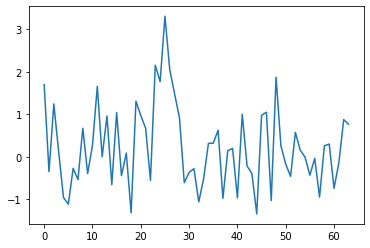

In [81]:
plt.plot(obs0['y'])